### Testing multiple models on the Irish House price Index.  
 

All models were trained on data from 1980 until 2012 and then tested on unseen data from 2012 to 2017. Data is Quarterly. Variables were not adjusted for inflation.
### Dependent variable(target): 
Irish House price index. CSO index backcast prior to 2005 with the Department of Housing national house price index.

 
### Independent variables(predictors):        

A flat interest rate yield curve was assumed for any variable containing an interest rate.
 
1. AFFORDABILITY:   Derivation of the ESRI annuity variable(2) reflecting a discounted portion of income available for                     mortgage payments. 
2. AVE_ANNUAL_MORT: Value of average national mortgages adjusted by prevailing mortgage rate(pa). 
 
3. BCOST:           Building costs from Department of Housing.
 
4. COST_CAPITAL:    Takes the average value of new mortgages approved in a quarter and discounts it by the prevailing residential mortgage interest rate for an assumed 25yr mortgage.  

5. LTV_DEMAND_1:  This is a derivation of the McQuinn(2) and DUCA(1) LTV variable. LTV_DEMAND_1 is the average quarterly national LTV adjusted for the number of mortgages issued per capita and then with demand side influences like national disposable income and unemployment stripped out of the variable in an attempt to reflect a housing credit supply variable. Coefficients used to strip the variable were obtained via a simple OLS Linear Regression model. 

6. NGDP:            Nominal GDP from CSO backcast prior to 1997.  

7. RENTCSO:        CSO Rental Index. 
 
8. STOCK_PC:        Housing Supply numbers from Department of Housing adjusted for Population.     
  
9. TDI_PC:         Disposable Income backcast to 1997 adjusted with Population figures from the CSO.  

10. USER_CAP_COST: Discounts average mortage by prevailing mortgage interest rate but does not adjust by disposable income.
 
11. URX:             Irish Unemployment CSO/NewCronos. 
 

### Data transformation:
1. Logs were taken of all data.
2. Data was then differenced.
3. Data was scaled to within a range of -1 to +1 for the Neural models and the OLS model but not the ECM model. 
4. Data was reversed for the plot below to check how the model performed against the actual nominal House price  index.

### Models:  
1. Fully connected neural network. In the first layer there is both regularization of kernel and activation weights plus dropout of one in two neurons happening. Leaky Relu was used to allow for some negative slope in the activation function. 

2. LSTM stateful model. Since this is time series the LSTM model chosen was stateful and the single objective was to test the memory capacity of the model across the entire time series of the training data. This model had more layers and neurons than the Dense Fully connected model above.There was no regularization or dropout employed in this model. Dimensionality was reduced through the net down into the last hidden layer.

3. Simple OLS with first differences and no lags of either side of the equation.

4. Error correction model followed two step Engle Granger ECM model and took the residuals from a linear OLS regression of the non-differenced variables in question and those residuals were tested outside the notebook for stationarity via an ADF test. The right hand side of the final ECM equation below contains the lagged error correction term from the first linear model, the lag of the differenced dependent variable, and the lag of the differenced independent variables. Logs of Y and X variables were used in both models.

The chart at the bottom shows the relative performance of the models versus the unseen test data. 
#### Footnote: 
A special thank you to Professor Kieran McQuinn from the ESRI in Dublin who supplied most of raw data used in the analysis below. Neither Professor McQuinn or the ESRI had any involvement with the work contained below. I did though draw from Professor McQuinn's work in that some of the features I engineered were loose derivations of independent variables created by Professor McQuinn(2) and also Duca(1).  
#### References:
1. Duca, J.V., J. Muellbauer and A. Murphy(2011). House prices and credit constraints:Making sense of the U.S. experience, Economic Journal, Vol. 121, pp. 533-551.
2. Kieran McQuinn(2017). Irish house prices: Déjà vu all over again?,QEC Special Article, Economic & Social Research Institute
 
 
1. Dickey, David A. and Fuller, Wayne A. “Likelihood Ratio Statistics for Autoregressive Time Series with a Unit Root.” IGonotnemico 49 (July 1981): 1057-72. 

2. Engle, Robert F. and Byund Sam Yoo. “Forecasting and Testing in a Cointegrated System.” Joamal of Econometrics 35 (1987): 143-59.

3. Engle, Robert F. and C. W. J. Granger. “Cointegration and Error-Correction Representation, Estimation, and Testing.” Economem~a (March 1987): 25 l-76. 

4. Granger, C. W. J., and P. Newbold. “Spurious Regressions in Econometrics.” Journalof EconomemiGs (July 1974): 11 l-20. 

5. Phillips, P. C. B. “Understanding Spurious Regressions in Econometrics.” JoumaL of Econometrics 33 (1986): 3 1 l-40. 
 
#### February 2019.


In [1]:
#Pandas
import pandas as pd
from pandas import Series
from pandas import DataFrame
from pandas import concat
#Numpy
import numpy as np
from numpy import array
#Plot dependencies
import matplotlib.pyplot as plt
from matplotlib import pyplot
#Sklearn 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
 
#Tensorflow backend and keras 
import tensorflow 
import keras
from keras import losses
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras import regularizers
from keras import optimizers
from keras.layers import Dropout, Input
from keras.layers.noise import GaussianNoise
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint
from keras.constraints import max_norm
from keras.constraints import MinMaxNorm
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
def read_prepare_data():
   global scaler,data,y,X,X_log,y_log,X_diff,y_diff,X_train_d,y_train_d,X_test_d,y_test_d,y_t,yy
   data=  pd.read_excel('/Users/brianfarrell/Desktop/irish_housing_data.xlsx',sheet_name='data')
   data.fillna(method='ffill',inplace=True)
   #Convert to numpy arrays    
   y=np.array(data['PCSO2'])    
   X=np.array(data[['BCOST', 'NGDP','RENTCSO', 'URX','TDI_pc', 'stock_pc',
         'user_cap_cost', 'Ave_annual_mort', 'affordability', 'cost_capital', 'ltv_demand_1']])    
   #Get logs of X and Y matrices    
   y_log=np.log(y)
   y_log.shape=(149,1)
   X_log=np.log(X)
   X_log.shape=(149,11)
   #Differences X and y 
   y_diff= np.diff(y_log,axis=0)
   y_diff.shape=(148,1)
   y_diff.round(decimals=3)  
   X_diff=np.diff(X_log,axis=0)
   X_diff.shape=(148,11)
   X_diff.round(decimals=3)
   #Scale X and y to between -1 and +1
   scaler = MinMaxScaler(feature_range=(-1, 1))
   #Split data into train test split at 2012Q4,
   X_train=X_diff[:130,:]
   X_train.shape=(130,11)
   X_test=X_diff[130:,:]
   X_test.shape=(18,11)
   y_train=y_diff[:130]
   y_train.shape=(130,1)
   y_test=y_diff[130:]
   y_test.shape=(18,1)
   y_t=y[130:]
   #Scale X matrix 
   X_train_s=scaler.fit_transform(X_train)    
   X_test_s=scaler.transform(X_test)
   #Scale y vector
   y_train_s=scaler.fit_transform(y_train)
   y_test_s=scaler.transform(y_test)     
   #Dense network splits
   X_train_d =X_train_s 
   X_train_d.shape=(130,11)
   X_test_d=X_test_s 
   X_test_d.shape=(18,11)    
   y_train_d=y_train_s
   y_train_d.shape=(130,1)
   y_test_d=y_test_s
   y_test_d.shape=(18,1) 
   #For plot below 
   i=data['PCSO2'].index
   ii=i[130:-1]
   yy=pd.DataFrame(data['PCSO2'],index=ii)
   return yy,scaler
   
def plot_model_forecast(y_hat_d,y_hat_ls,y_hat_r,y_hat_e):   
    fig = plt.figure(figsize=(20,5)) 
    plt.suptitle('Compare model predictions of the Irish House price index',fontsize=17)  
    ax = plt.axes()  
    ax.plot(y_hat_d,color='pink',lw=2,dashes=[10,2]) 
    ax.plot(y_hat_ls,color='red',lw=2,dashes=[10,2])
    ax.plot(y_hat_r,color='orange',lw=2,dashes=[10,2])
    ax.plot(y_hat_e,color='green',lw=2,dashes=[10,2])
    ax.plot(yy,color='black',lw=3,dashes=[2, 1])
    ax.legend(['Fully Connected Neural Network model','LSTM Sateful model','OLS Model ', 'OLS_Error Correction model','Irish House price index'])
    plt.xlabel('Time',fontsize=15)
    plt.ylabel('Index level',fontsize=15)
    plt.show()    
         
def run_dense_model():
    global y_hat_d
    read_prepare_data()         
    model_d = Sequential()
    model_d.add(LeakyReLU(alpha=0.3)) 
    model_d.add(Dense(200,input_dim=11,kernel_regularizer=regularizers.l2(0.1),
                activity_regularizer=regularizers.l1(0.1),kernel_constraint= MinMaxNorm(min_value=-1.0, max_value=1.0, rate=1.0, axis=0)))    
    model_d.add(Dropout(0.5))
    model_d.add(Dense(1,kernel_constraint= MinMaxNorm(min_value=-1.0, max_value=1.0, rate=1.0, axis=0),activation= 'linear'))
    model_d.compile(loss='mean_absolute_percentage_error',optimizer='Adam')   
    history = model_d.fit(X_train_d, y_train_d, epochs=500  ,batch_size=1,verbose=0,shuffle=True)     
    model_d.evaluate(X_test_d, y_test_d,verbose=2,batch_size=1)
    pred_d = model_d.predict(X_test_d, batch_size=1,verbose=0)
    #Invert predictions back to original Index scale
    y_hat= scaler.inverse_transform(pred_d)    
    y_hat.round(decimals=3)    
    y_hat_log_d= y_log[129:147]+y_hat  
    y_hat_d=np.exp(y_hat_log_d) 
    y_hat_d.round(decimals=1)     
         
def run_lstm_model():
    global y_hat_ls
    X_train_ls=X_train_d
    X_test_ls=X_test_d
    y_train_ls=y_train_d
    y_test_ls=y_test_d
    X_train_ls.shape=(130,1,11)
    X_test_ls.shape=(18,1,11)
    global pred_statefull
    timesteps = 1
    batch_size = 1
    data_dim=11
    model_s = Sequential()
    model_s.add(LSTM(100, return_sequences=True, stateful=True,
               batch_input_shape=(batch_size, timesteps, data_dim)))
    model_s.add(LSTM(100, return_sequences=True, stateful=True))
    model_s.add(LSTM(50, stateful=True))
    model_s.add(Dense(1, activation='linear'))
    model_s.compile(loss='mean_absolute_percentage_error',
              optimizer='adam',
              metrics=['mae']) 
    for i in range(500):
        history= model_s.fit(X_train_ls, y_train_ls,
          batch_size=batch_size, epochs=1,validation_split=0.10,verbose=0, shuffle=False)
        model_s.reset_states()    
    model_s.evaluate(X_test_ls, y_test_ls,  batch_size=batch_size,verbose=0)
    pred_stateful = model_s.predict(X_test_ls, batch_size=batch_size,verbose=0)
    y_hat_s= scaler.inverse_transform(pred_stateful)    
    y_hat_s.round(decimals=3)      
    y_hat_log_s= y_log[129:147]+y_hat_s   
    y_hat_ls=np.exp(y_hat_log_s)   
    y_hat_ls.round(decimals=1)    
    
def run_ols():
    global y_hat_r
    X_train_d.shape=(130,11)
    X_test_d.shape=(18,11)
    reg = LinearRegression().fit(X_train_d, y_train_d)
    pred_reg= reg.predict(X_test_d)
    y_hat_diff_log_r= scaler.inverse_transform(pred_reg)
    y_hat_diff_log_r.round(decimals=4) 
    y_hat_log_r= y_log[129:147]+y_hat_diff_log_r     
    y_hat_r=np.exp(y_hat_log_r)
    y_hat_r.round(decimals=1)
    
def run_ecm():
    global y_hat_e
    #Read in data containing lags and error correct term     
    #Engle Granger two step ECM.
    #residuals  are I(o) from first linear model of Y and X and residuals are
    #lagged along with and one period lag of differed y and x variables for second model.
    ECM_X=  pd.read_excel('/Users/brianfarrell/Desktop/irish_housing.xlsx',sheet_name='ECM_X')
    ECM_Y=  pd.read_excel('/Users/brianfarrell/Desktop/irish_housing.xlsx',sheet_name='ECM_Y')
    ECM_X_train= ECM_X.iloc[:129,:]
    ECM_X_test= ECM_X.iloc[129:,:]
    ECM_y_train= ECM_Y.iloc[:129]
    ECM_y_test=ECM_Y.iloc[129:]
    final_ecm = LinearRegression().fit(ECM_X_train,ECM_y_train)
    pred_ecm_final= final_ecm.predict(ECM_X_test)
    pred_ecm_resid= ECM_y_train-(final_ecm.predict(ECM_X_train))
    pred_ecm_final.round(decimals=4)
    y_hat_ecm= y_log[128:146] + pred_ecm_final
    y_hat_e=np.exp(y_hat_ecm)
    y_hat_e.round(decimals=1)

def run_models():
    run_dense_model()
    run_lstm_model()
    run_ols()
    run_ecm()
    
def plot_models():     
    plot_model_forecast(y_hat_d,y_hat_ls,y_hat_r,y_hat_e)
       
def compare_models():
    run_models()
    plot_models()

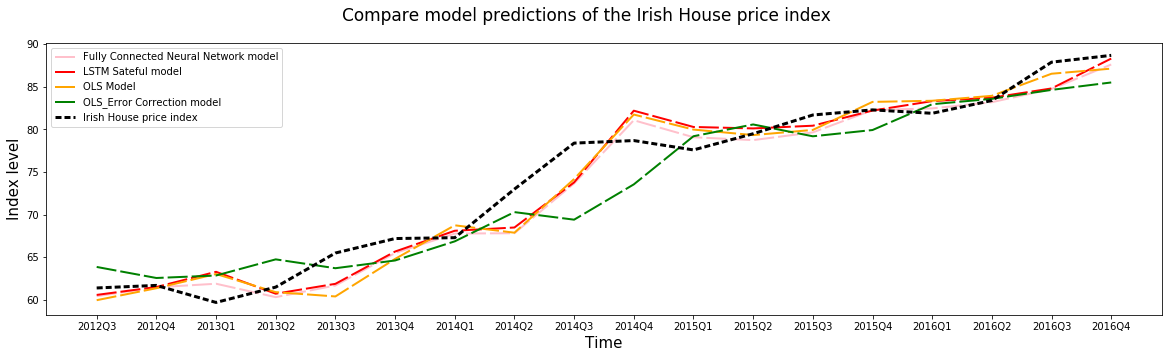

In [3]:
compare_models() 